## Analysis of cluster data produced by mPIXdaq
                                                    Günter Quast, Jan. 2026

This code analyzes the properties of pixel clusters derived from miniPIX frames 
uning the class `frameAnalyzer` of the Python package *mpixdaq*.   
The documentation of the class is shown here:

``` 
Class frameAnalyzer:
    Analyze frame data

    - find clusters using scipy.ndimage.label()
    - compute cluster energies
    - compute position and covariance matrix of x- and y-coordinates
    - compute covariance matrix of the energy distribution
    - analyze cluster shape (using eigenvalues of covariance matrix)
    - construct a tuple with cluster properties

    Note: this algorithm only works if clusters do not overlap!

    Args:

    - 2d-frame from the miniPIX

    __call__() method Returns:

    - self.pixel_clusters: list of tuples with properties per cluster: mean of x and y
      coordinates, the number of pixels, energy, eigenvalues of covariance matrix and
      their orientation as an angle in range [-pi/2, pi/2] and the minimal and maximal
      eigenvalues of the covariance matrix of the energy distribution. The format is:
      ( (x, y), n_pix, energy, (var_mx, var_mn), angle, (xEm, yEm), (varE_mx, varE_mn) )

    - self.pixel_lists: list of pixel indices contributing to each cluster, where
      pixel index is x + y

    self.cluster_pxl_lst is a list of dimension n_clusters + 1 and contains the pixel
    indices contributing to each of the clusters. self.cluster_pxl_lst[-1] contains
    the list of single pixels

    A static method, get_cluster_summary(pixel_clusters), provides summary information

    - n_pixels: number of pixels with energy > 0
    - n_clusters: number of clusters  with >= 2 pixels
    - n_cpixels: number of pixels per cluster
    - circularity: circularity per cluster (0. for linear, 1. for circular)
    - cluster_energies: energy per cluster
    - single_energies: energies in single pixels
```

These properties per cluster are exported to a file in *yaml* or *csv* format containing    
  >  **time** **x_mean** **y_mean** **n_pix** **energy** **var_mx** **var_mn** **angle** **xE_mean** **yE_mean** **varE_mx**  **varE_mn**

The *yaml* file also contains a list with indices and energies of all pixels belonging to a cluster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import gzip

from matplotlib.colors import LogNorm

#### Import data and add derived quantities

In [8]:
# *==* import data in a pandas data frame

filename = "data/BlackForestStone_clusters.yml.gz"  # properties and pixel energies of 20'000 clusters
# filename = "data/BFstone_clusters.csv.gz"  # properties of 50'000 clusters

if '.csv' in filename:  # from csv file
    df = pd.read_csv(filename)
elif '.yml' in filename:  # or from file in yaml format
    f = gzip.open(filename, 'rb') if filename.split('.')[-1] == 'gz' else open(filename, 'r')
    _d = yaml.load(f, Loader=yaml.CLoader)
    cluster_data = _d['cluster_data']  #  1st is list of cluster properties, 2nd is list of [pixel index, enery] pairs
    cluster_properties = [cluster_data[i][0] for i in range(len(cluster_data))]
    df = pd.DataFrame(data=cluster_properties, columns=_d['keys'])
    print(_d['keys'])
else:
    print("!!! unknown file format")

# *==* add some derived quantities
#  - circularity defined as the ratio of the smaller and the larger eigenvalue
#    of the covariance matrix of the pixels in a cluster
df['circularity'] = df['var_mn'] / np.maximum(df['var_mx'].to_numpy(), 0.001)
#  -flatness (of energy distribution) as the ratio of
#    maximum variances of pixel and energy distributions in clusters
df['flatness'] = df['varE_mx'] / df['var_mx']

# *==* show data
display(df)

['time', 'x_mean', 'y_mean', 'n_pix', 'energy', 'var_mx', 'var_mn', 'angle', 'xE_mean', 'yE_mean', 'varE_mx', 'varE_mn']


,time,x_mean,y_mean,n_pix,energy,var_mx,var_mn,angle,xE_mean,yE_mean,varE_mx,varE_mn,circularity,flatness
0,0.0,72.50,4.00,14,487.0,4.396,0.854,0.594,72.95,4.39,3.733,0.932,0.194268,0.849181
1,0.0,168.50,14.00,2,10.0,0.250,0.000,-1.571,168.50,14.00,0.250,0.000,0.000000,1.000000
2,0.0,235.86,26.86,7,337.0,1.406,0.267,0.659,235.89,27.15,1.006,0.114,0.189900,0.715505
3,0.0,165.00,62.44,9,197.0,4.571,0.120,0.758,165.21,62.72,5.597,0.099,0.026252,1.224459
4,0.0,128.40,94.60,15,2752.0,1.333,1.013,0.785,128.40,94.58,0.318,0.290,0.759940,0.238560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19634,999.5,4.60,53.80,5,160.0,0.600,0.200,0.322,4.80,54.31,0.398,0.124,0.333333,0.663333
19635,999.5,186.50,148.50,4,65.0,0.250,0.250,0.000,186.51,148.85,0.250,0.130,1.000000,1.000000
19636,999.5,190.55,193.82,11,374.0,3.770,0.263,-1.301,190.42,193.87,4.301,0.253,0.069761,1.140849
19637,999.5,208.50,233.50,4,116.0,0.250,0.250,0.000,208.84,233.60,0.244,0.132,1.000000,0.976000


#### Produce an overview of the distributions of the input variables

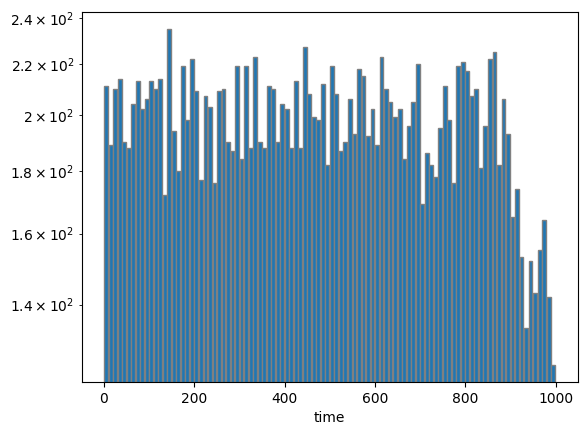

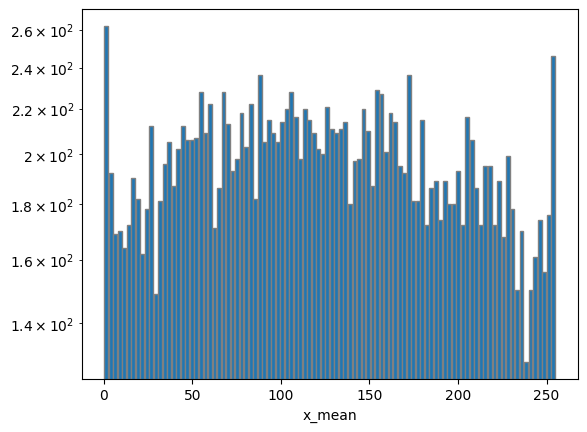

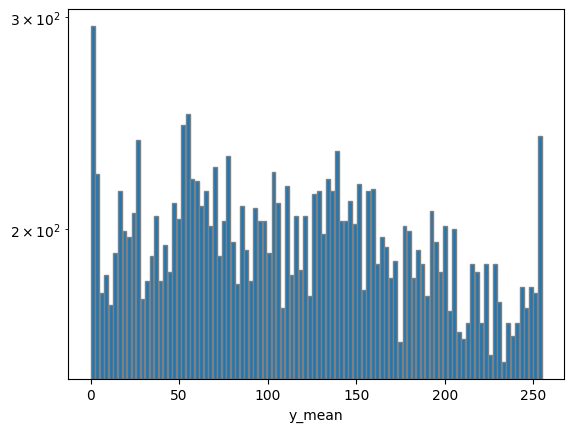

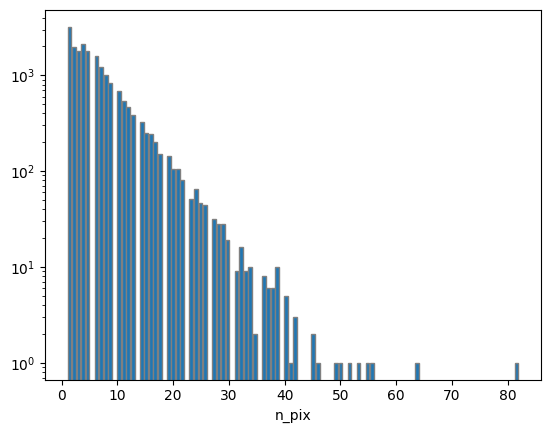

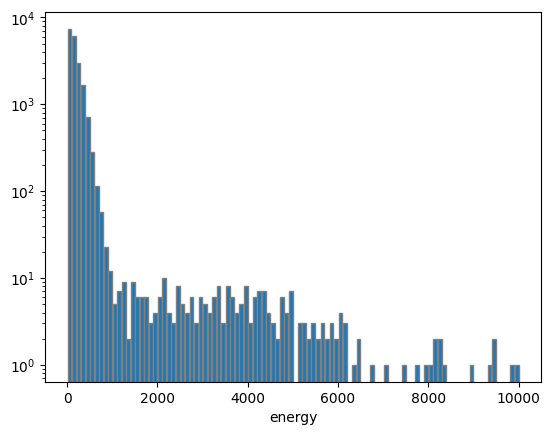

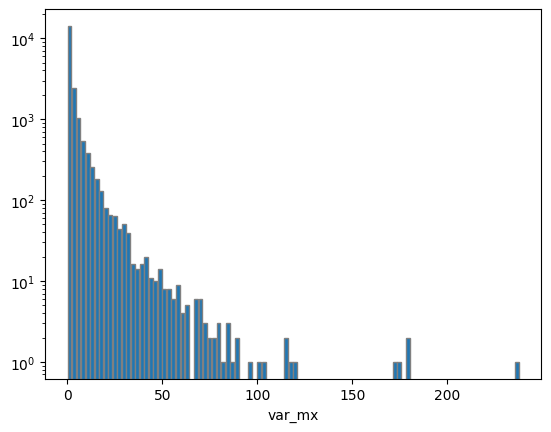

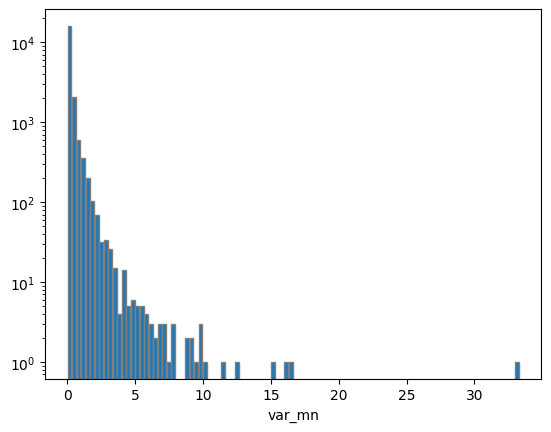

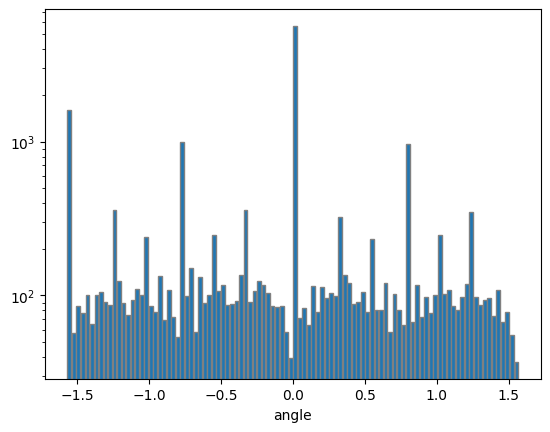

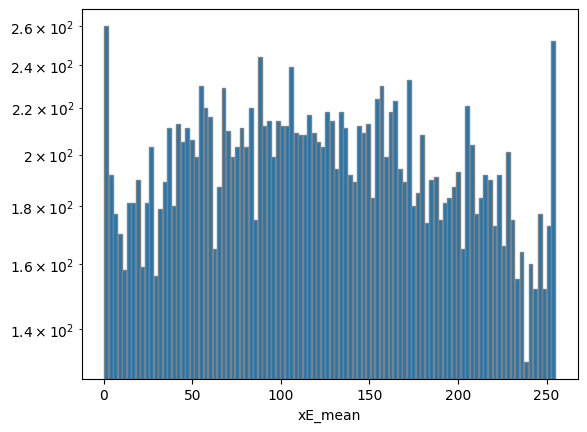

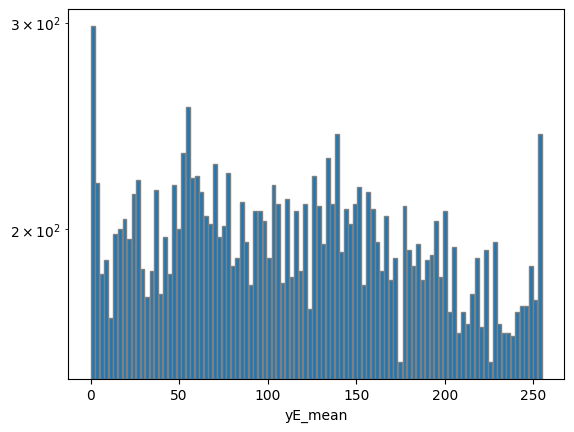

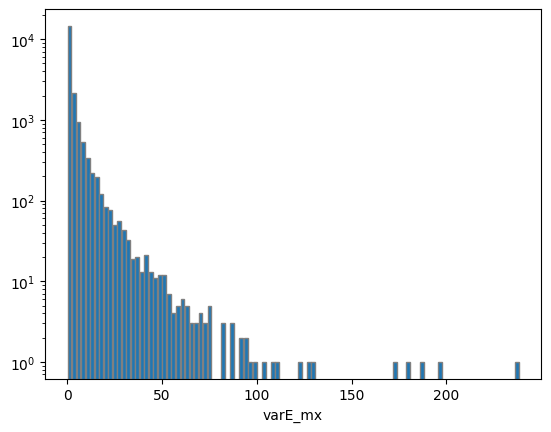

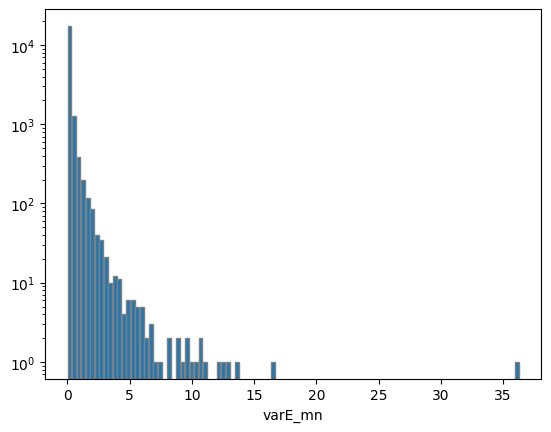

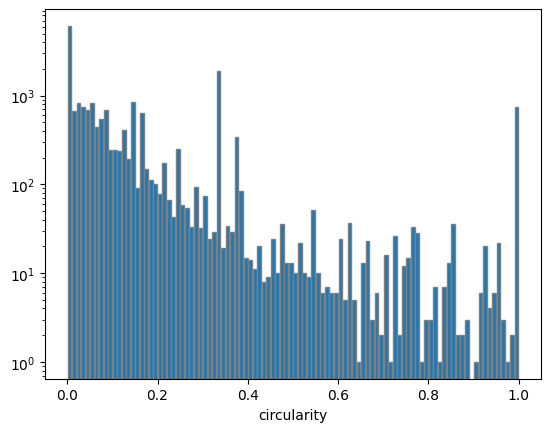

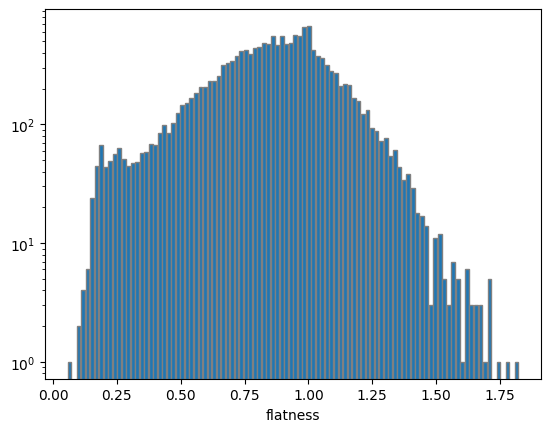

In [3]:
def plt_keys(df):
    for key in df.keys():
        _ = plt.hist(df[key][df[key] != np.nan], bins=100, rwidth=0.85, edgecolor='grey')
        plt.yscale("log")
        plt.xlabel(key)
        plt.show()


plt_keys(df)

#### Spacial distribution of clusters

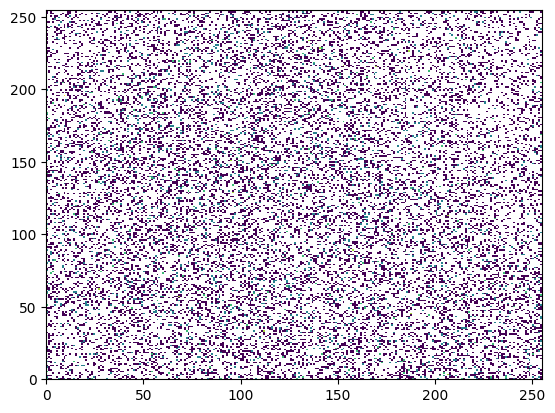

In [4]:
_ = plt.hist2d(df['x_mean'], df['y_mean'], bins=(256, 256), norm=LogNorm())
plt.show()

### Check arrival times

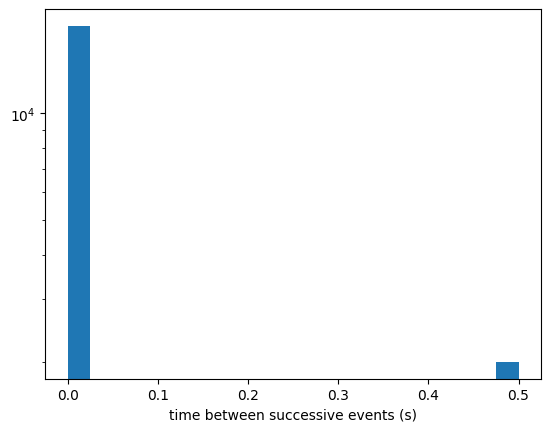

In [5]:
# difference between two events
if 'time' in df.keys():
    _dT = df['time'][1:].to_numpy() - df['time'][:-1].to_numpy()
    _ = plt.hist(_dT, bins=20)
    plt.xlabel("time between successive events (s)")
    plt.yscale('log')

#### 2d plots for different cluster types (circularity, varE)

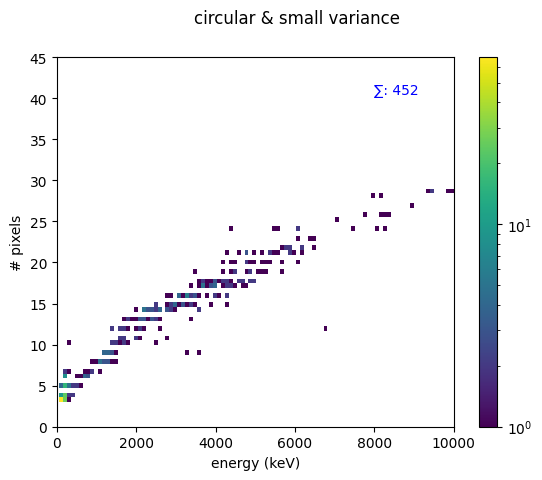

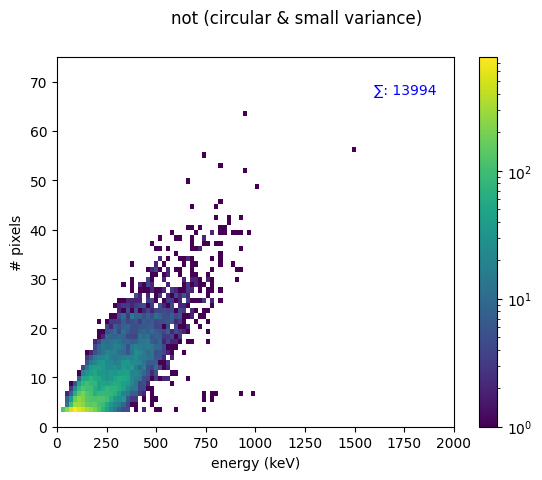

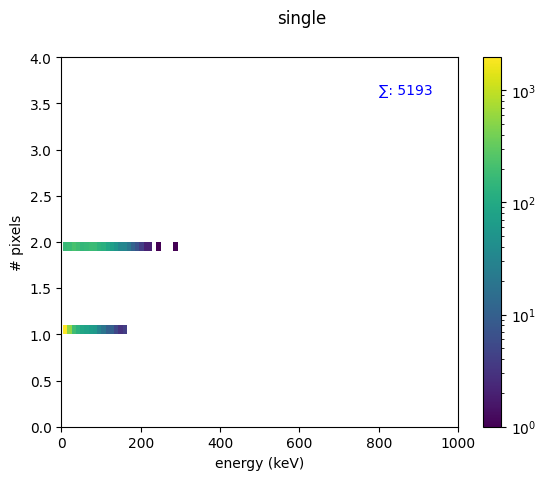

In [6]:
circularity_cut = 0.3
is_circular = df['circularity'] >= circularity_cut
is_linear = df['circularity'] < circularity_cut
is_single = df['n_pix'] <= 2

flatness_cut = 0.4
flatness = df['flatness']
has_small_varEmx = flatness < flatness_cut
is_alpha = is_circular & has_small_varEmx

_ = plt.hist2d(df['energy'][is_alpha], df['n_pix'][is_alpha], bins=(100, 45), norm=LogNorm())
# _ = plt.hist2d(df['energy'], df['n_pix'], bins = (100, 55), norm=LogNorm())
plt.xlim(0, 10000)
plt.ylim(0, 45)
plt.suptitle("circular & small variance")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_alpha.sum()}", transform=_ax.transAxes, color='b')
plt.show()

_msk = ~is_alpha & ~is_single
_ = plt.hist2d(df['energy'][_msk], df['n_pix'][_msk], bins=(100, 75), norm=LogNorm())
plt.xlim(0, 2000)
plt.ylim(0, 75)
plt.suptitle("not (circular & small variance)")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {_msk.sum()}", transform=_ax.transAxes, color='b')
plt.show()

_ = plt.hist2d(df['energy'][is_single], df['n_pix'][is_single], bins=(100, 10), norm=LogNorm())
plt.xlim(0, 1000)
plt.ylim(0, 4)
plt.suptitle("single")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_single.sum()}", transform=_ax.transAxes, color='b')
plt.show()

#### Discussion

These scatter plots show a very clear structure arising from the propeties of the detected particles.

  - alpha particles produce small, round clusters and deposit all of their energy in a small volume
  - beta particles produce long tracks in the material
  - photons produce - typically low-energy - electrons leading to signatures with very few or
    even isolated pixels

Note that some of the long tracks may have a significant "circularity" if they are bent !